In [1]:
%%capture
%pip install --user --upgrade pyarrow

In [2]:
import time, yaml
import neo4j_pq as npq
import neo4j_arrow_client as na
import pyarrow as pa
from pyarrow import parquet as pq
from time import sleep

## Managing large datasets with Apache Arrow

<p>One of the main capibilities of Apache Arrow is the ability to deal with <strong>memory-mapped files</strong>,<br>
this allows Arrow to read datasets that are bigger than the available RAM without incurring any additional memory cost.<br>

With the PyArrow ParquetDataset module we can create a dataset of memory-map parquet files, it can then be fragmented and processed in batches. <br>
    
In adition to local storage, PyArrow also supports cloud object storage such as:
<ul>
  <li>Amazon Simple Storage (S3)</li>
  <li>Google Cloud Storage (GCS)</li>
  <li>Microsoft Azure Blob Storage</li>
</ul>
<p>
 
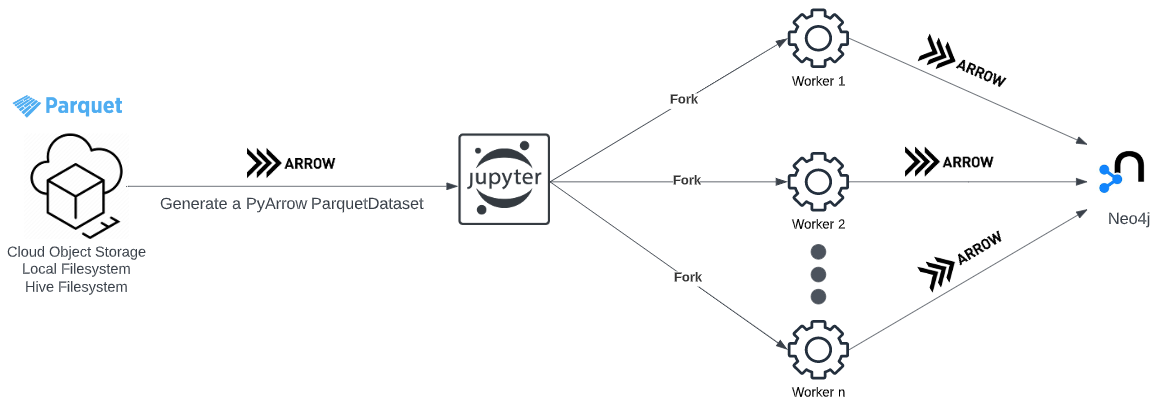

## Define your configuration
<p>The <strong>config.yaml</strong> file sets the configuration values for: 
<ul>
  <li>Neo4j Database</li>
  <li>Dataset</li>
  <li>Workers</li>
</ul>
<p>


In [3]:
config = yaml.safe_load(open('config.yaml'))
print(yaml.dump(config, default_flow_style=False, sort_keys=False))

neo4j:
  host: 34.172.112.204
  port: 8491
  user: neo4j
  password: '!twittertest'
  tls: false
  concurrency: 50
  database: users200m
dataset:
  node_parquet_files_uri: gs://yan-users-export/pqdataset/nodes
  relationship_parquet_files_uri: gs://yan-users-export/pqdataset/relationships
worker:
  concurrency: 50
  arrow_table_size: 1000000



## Let's sample our PyArrow ParquetDataset

<p>Using the config.yml dataset uri values, we create our nodes_dataset & edges_dataset using pyarrow ParquetDataset module.<br>
One Important requirement is that your file uri values contains the <strong>nodes & relationships</strong> string.<br>
In your storage environment you can have sub-folders per node label and relationship type, pyarrow will automatically detect nested structures.
<p>

In [4]:
node_parquet_files_uri = config['dataset']['node_parquet_files_uri']
relationship_parquet_files_uri = config['dataset']['relationship_parquet_files_uri']

nodes_dataset = pq.ParquetDataset(node_parquet_files_uri, use_legacy_dataset=False)
rels_dataset = pq.ParquetDataset(relationship_parquet_files_uri, use_legacy_dataset=False)


#### Once our datasets are created we can break them into memory-mapped Fragments, this can also be done at no additional memory cost

In [5]:
node_work = [fragment for fragment in nodes_dataset.fragments]
relationship_work = [fragment for fragment in rels_dataset.fragments]
print(f"Generated {len(node_work)} node dataset fragments and {len(relationship_work)} relationship fragments")

Generated 57 node dataset fragments and 310 relationship fragments


#### You can convert a node dataset Fragment to an arrow table using the to_table() method

<p> The Neo4j server expects the arrow node records to adhere to a specific order and schema:
<ul>
  <li>The first column represents the node identifier</li>
    <ul>
        <li>Supported types: <strong>integer, string<strong></li><br>
    </ul>
  <li>The second column represents the node labels</li>
    <ul>
        <li>Supported types: <strong>string, integer or string[]</strong></li><br>
    </ul>    
  <li>Any aditional column is interpreted as a node property</li>  
</ul>
More information can be found in: <a href="https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#arrow-send-nodes">https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#arrow-send-nodes</a>
<p>

In [6]:
print(node_work[0].to_table())

pyarrow.Table
user_id: string
labels: string
name: string
----
user_id: [["212240358","173575741","111959947","20054822","12278518",...,"158102246","258554135","117876885","101979382","264211898"],["147145884","125036395","84020474","215636498","100879825",...,"57493253","131601585","127377942","17872870","73716040"],...,["142199754","222917375","156301279","208879621","65697919",...,"178591346","19840886","22326095","114213958","55948038"],["122903861","145062645","20783812","129135084","205683568",...,"93461257","185635399","185888633","9849853","224110468"]]
labels: [["User","User","User","User","User",...,"User","User","User","User","User"],["User","User","User","User","User",...,"User","User","User","User","User"],...,["User","User","User","User","User",...,"User","User","User","User","User"],["User","User","User","User","User",...,"User","User","User","User","User"]]
name: [["Sydney Mante","Kirk Price","Bettie Abshire","Rowan Franecki","Lenora Ryan",...,"Edwin Heidenreich","Dr. P

#### You can convert a relationship dataset Fragment to an arrow table using the to_table() method
<p> The Neo4j server expects the arrow relationship records to adhere to a specific order and schema:
<ul>
  <li>The first column represents the source node identifier</li>
    <ul>
        <li>Supported types: <em><strong>integer, string<strong></em></li><br>
    </ul>

  <li>The second column represents the target node identifier</li>
    <ul>
        <li>Supported types: <em><strong>integer, string<strong></em></li><br>
    </ul>
  <li>The third column represents the relationship type</li>
    <ul>
        <li>Supported types: <em><strong>integer, string<strong></em></li><br>
    </ul>
  <li>Any additional column is interpreted as a relationship property</li>  
</ul>
More information can be found in <a href="https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#arrow-send-relationships">https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#arrow-send-relationships</a>
</p>

In [7]:
print(relationship_work[0].to_table())

pyarrow.Table
source_id: string
destination_id: string
type: string
connectedDate: string
----
source_id: [["256491118","159924485","160433055","54605431","96458256",...,"63808864","199643296","10031018","17674881","226020022"],["4974573","267529786","224513848","70072286","234764953",...,"153827556","25659075","182864331","55842690","143686528"],...,["39401650","96146312","58511945","197732027","114344661",...,"32314439","255818297","258099850","59014527","204416417"],["231652001","27095873","41225845","141826693","235003581",...,"150823173","275616217","251032936","140177726","198996541"]]
destination_id: [["22241322","192489986","265416634","197803012","95555652",...,"263933925","29135552","224563112","97621313","256065272"],["134760853","227638743","122243685","201854285","85358721",...,"8332108","159575361","225733715","218682897","202368361"],...,["92958081","95291546","163238293","108259171","52251500",...,"115126071","50850031","42751807","204922812","132760932"],["220260281","

## Ingestion Process

<p>
    <ul>
        <li>Create your <strong>Neo4jArrowClient</strong> with the defined configuration, this will allow you to orchestrate the graph database load</li><br>
        <li>We build work tasks for our worker pool, each task contains the PyArrow ParquetDataset Fragment, each Fragment gets broken into RecordBatches of the size defined in our configuration</li>
    </ul>    
</p>

In [8]:
config = yaml.safe_load(open('config.yaml'))
print(yaml.dump(config, default_flow_style=False, sort_keys=False))

neo4j:
  host: 34.172.112.204
  port: 8491
  user: neo4j
  password: '!twittertest'
  tls: false
  concurrency: 50
  database: users200m
dataset:
  node_parquet_files_uri: gs://yan-users-export/pqdataset/nodes
  relationship_parquet_files_uri: gs://yan-users-export/pqdataset/relationships
worker:
  concurrency: 50
  arrow_table_size: 1000000



In [9]:
client = na.Neo4jArrowClient(host = config['neo4j']['host'],
                             port = config['neo4j']['port'],
                             user = config['neo4j']['user'], 
                             password = config['neo4j']['password'],
                             tls = config['neo4j']['tls'], 
                             concurrency = config['neo4j']['concurrency'], 
                             database = config['neo4j']['database'])

print(f"Created {client}")

Created Neo4jArrowClient{neo4j@34.172.112.204:8491/users200m}


### Let's Build the Graph Database!

Now that we have our `Neo4jArrowClient`, we can orchestrate our graph database load.

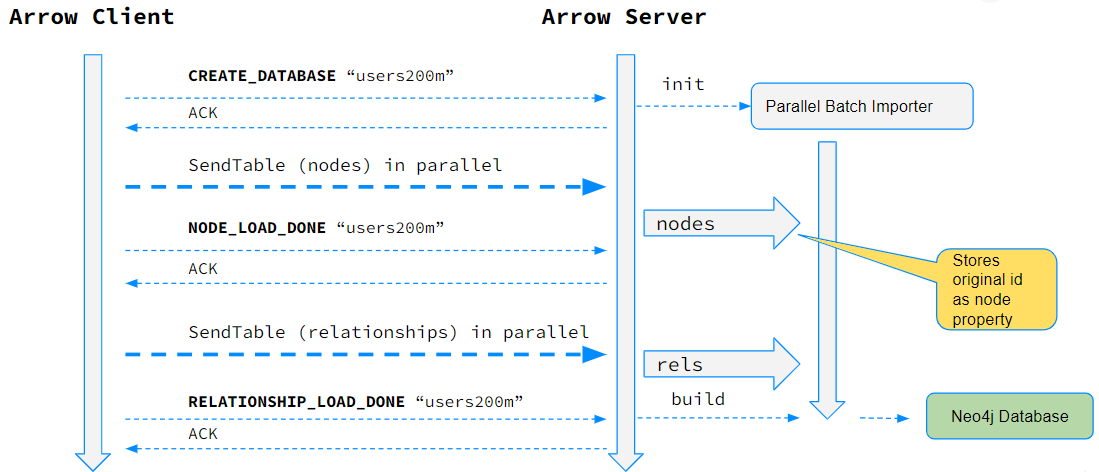

#### 1. Initializing the Import Process
<p>We send our <em><strong>CREATE_DATABASE</strong></em> signal, letting Neo4j know we are beginning our load.<br>
    <ul>
        <li>The action body is a JSON document containing metadata for the import process, defined in the below cell as import_config</li>
        <li>The server acknowledges creating the import process by sending a result JSON document which contains the name of the import process</li>
        <li>If an error occurs, e.g., if the graph already exists or if the server is not started, the client is informed accordingly.</li>
    </ul>
The complete table for the below configuration settings can be found here <a href="https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#_creating_a_neo4j_database">https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#_creating_a_neo4j_database</a>
</p>

##### 1a. Supported node identifier types
<p>
    <ul>
      <li>The <strong>id_type</strong> configuration parameter has two possible options <strong>INTEGER</strong> and <strong>STRING</strong>, with <strong>INTEGER</strong> being the default</li>
      <li>If set to <strong>INTEGER</strong>, the node id columns for both nodes and relationship records (sourceNodeId and targetNodeId) of your of your arrow tables, are expected to be represented as BigIntVector.</li>
      <li>For the <strong>STRING</strong> id type, the server expects the identifiers of your arrow tables to be represented as VarCharVector</li>
   </ul>
In both cases, the original id is being stored as a property on the imported nodes. The property key can be changed by the id_property config option.
</p>

In [10]:
import_config = {
                "name": config['neo4j']['database'], 
                "concurrency": config['neo4j']['concurrency'],
                "high_io": True,
                "force": True,
                "record_format": "aligned",
                "id_property": "id",
                "id_type": "STRING"
            }

msg = client.create_database(config=import_config)
print(f"✅ Ready to load nodes for {msg['name']}")

✅ Ready to load nodes for users200m


#### 2a. Send our Nodes!
We can send data in parallel to speed up the ingestion process, we fan out the node
dataset fragments to numerous workers processes.

Each worker will receive a dataset fragment along with a copy of the `Neo4jArrowClient` config, <br>
each fragment gets broken into RecordBatches of the size defined in our configuration the **default is 1,000,000**
and streamed over to Neo4j using our client.

In [11]:
node_results, timing = npq.fan_out(client, 
                                   config['dataset']['node_parquet_files_uri'], 
                                   config['worker']['arrow_table_size'], 
                                   config['worker']['concurrency'])

total_nodes = sum([x["rows"] for x in node_results])
total_bytes = sum([x["bytes"] for x in node_results])

node_rate = int(total_nodes / timing)
data_rate = int(total_bytes / timing) >> 20

sleep(2)
print(f"Sent: {total_nodes:,} nodes in {round(timing, 2)}s (~{node_rate:,} nodes/s, ~{data_rate} MiB/s)")

Dataset <class 'pyarrow.parquet.core._ParquetDatasetV2'> created from: gs://yan-users-export/pqdataset/nodes
Using: 🚀 Neo4jArrowClient{neo4j@34.172.112.204:8491/users200m}
Spawning 50 workers 🧑‍🏭 to process 57 dataset fragments 📋
⚙️ Loading: [➶➶➶]
🏁 Completed in 25.63s


Sent: 280,737,646 nodes in 25.63s (~10,951,432 nodes/s, ~1794 MiB/s)


In [12]:
print("Signalling we're done loading nodes...\n")
msg = client.nodes_done()
print(f"✅ Loaded {msg['node_count']:,} nodes. Ready for edges!")

Signalling we're done loading nodes...

✅ Loaded 280,737,646 nodes. Ready for edges!


#### 3a. Send our Relationships
Time to stream the Relationships! Just like before, fan out the workload across a pool
of worker processes.

In [13]:
edge_results, timing = npq.fan_out(client, 
                                   config['dataset']['relationship_parquet_files_uri'], 
                                   config['worker']['arrow_table_size'], 
                                   config['worker']['concurrency'])

total_edges = sum([x["rows"] for x in edge_results])
total_bytes = sum([x["bytes"] for x in edge_results])

edge_rate = int(total_edges / timing)
data_rate = int(total_bytes / timing) >> 20

sleep(2)
print(f"Sent: {total_edges:,} relationships in {round(timing, 2)}s (~{edge_rate:,} edges/s, ~{data_rate} MiB/s)")

# Client object goes stale after very long running ingestion, this is a workaround
client.client = None

Dataset <class 'pyarrow.parquet.core._ParquetDatasetV2'> created from: gs://yan-users-export/pqdataset/relationships
Using: 🚀 Neo4jArrowClient{neo4j@34.172.112.204:8491/users200m}
Spawning 50 workers 🧑‍🏭 to process 310 dataset fragments 📋
⚙️ Loading: [➶➶➶➶➶➶➶➶➶➶➶]
🏁 Completed in 187.44s


Sent: 1,547,592,061 relationships in 187.44s (~8,256,298 edges/s, ~1408 MiB/s)


In [14]:
print("Awaiting neo4j database creation...\n")
msg = client.edges_done()

print(f"✅ Loaded {msg['relationship_count']:,} edges.")
print("😁 Happy Graphing! 🥳")

Awaiting neo4j database creation...

✅ Loaded 1,547,592,061 edges.
😁 Happy Graphing! 🥳
